In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt
from CustomClassesLRP import *
from ufuncs import *

import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# this code is adapted to cuda tensors, if run on cpu one needs to make small adjustments
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

# Data preparation

## Load data

In [3]:
# 200 training cfgs 
train_data = np.load('data/lrp_2d_data/train_data.npy')
print(train_data.shape)

# 100 test cfgs
test_data = np.load('data/lrp_2d_data/test_data.npy')
print(test_data.shape)

k = np.arange(-0.5, 0.505, 0.005)
N_kappas = k.shape[0]

(201, 200, 32, 32)
(201, 100, 32, 32)


## Adjust data for training

In [4]:
# turn labels into one-hot vectors with gaus smearing
sigma = 3 * 0.005
k_gaus = np.zeros((N_kappas,N_kappas))
for i, k_true in enumerate(k):
    k_gaus[i] = np.exp( -(k-k_true)**2/(2*sigma**2) ) 

labels_gaus = np.round(k_gaus, 12) 

# make random batches of data and allocate to cuda 
train, train_labels = shuffle_data(train_data, k_gaus, batchsize = 50)
test , test_labels  = shuffle_data(test_data  ,k_gaus, batchsize = 100, shuffle=False)

print('train data shape:  ', train.shape)
print('test data shape :  ', test.shape)

print('train labels shape:',  train_labels.shape)
print('test labels shape :',  test_labels.shape)

train data shape:   torch.Size([804, 50, 32, 32])
test data shape :   torch.Size([201, 100, 32, 32])
train labels shape: torch.Size([804, 50, 201])
test labels shape : torch.Size([201, 100, 201])


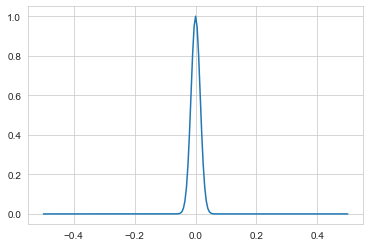

In [5]:
# visual confirmation of gaussian smearing 
plt.plot(k, k_gaus[100])

## Define model

In [6]:
# model = torch.load('models/lrp_2d/model_1.pt')
model = CNN_Classification(np.array([N_kappas]), n_filters = 4, n_dense_nodes = 1024)
print(model)

CNN_Classification(
  (conv): _Conv2dBlock(
    (conv): Sequential(
      (0): FirstConv2d(1, 4, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (1): CustomReLU()
      (2): CustomSumPool2d(norm_type=1, kernel_size=2, stride=None, ceil_mode=False)
    )
  )
  (dense): Sequential(
    (0): NextLinear(in_features=1024, out_features=256, bias=True)
    (1): CustomReLU()
    (2): NextLinear(in_features=256, out_features=201, bias=True)
    (3): CustomLeakyReLU(negative_slope=0.01)
  )
)


In [7]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [12]:
#train
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}")
    train_loop(train, train_labels, model, criterion, optimizer, lasso=True, factor=0.007) 
    test_loop(test, test_labels, model, criterion)
print("Done!")

Epoch 1
Avg test loss:  0.014131 

Epoch 2
Avg test loss:  0.013336 

Epoch 3
Avg test loss:  0.015653 

Epoch 4
Avg test loss:  0.012373 

Epoch 5
Avg test loss:  0.011863 

Done!


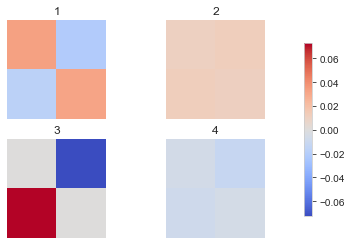

In [8]:
# plot filters
filters = model.conv.conv[0].weight.squeeze(1).detach().cpu().numpy()

i = 0
vmax = np.max(np.abs((filters)))
fig, axes = plt.subplots(nrows=2, ncols=2)

for ax in axes.flat:
    ax.set_title('{}'.format(1+i))
    im = ax.imshow(filters[i], vmin=-vmax, vmax=vmax, cmap='coolwarm')
    ax.axis('off')
    i+=1


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cbar_ax)

saveplot = False                                        # set to True if you want to save plots
if saveplot: plt.savefig('models/lrp_2d/filters.png')
plt.show()


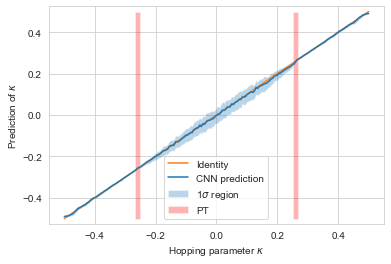

In [9]:
# plot prediction
preds, sigmas = predict(test, model, k)
plt.plot([k[0], k[-1]], [k[0], k[-1]], label='Identity', color = 'C1')
plt.plot(k, preds, label = 'CNN prediction')
plt.fill_between(k, preds+sigmas, preds-sigmas, alpha = 0.3, label = r'1$\sigma$ region' )


plt.ylabel(r'Prediction of $\kappa$')
plt.xlabel(r'Hopping parameter $\kappa$')

plt.bar([-0.26, 0.26], height = 1 , bottom = k[0], width = 0.015, color = 'r', alpha = 0.3, label='PT')
plt.legend()
plt.ylim([-0.525, 0.525])
if saveplot: plt.savefig('models/lrp_2d/preds')

In [10]:
# get relevances
relevances = []

for i, batch in enumerate(test):
    x = model(batch.unsqueeze(1))
    rel = model.relprop(x.cpu().detach().numpy(), layer_stop=3)
    rel = rel.reshape(100,4,256)
    relevances.append(np.mean(np.sum(rel, axis=2), axis = 0))
   
relevances = np.array(relevances).T
print(relevances.shape)


(4, 201)


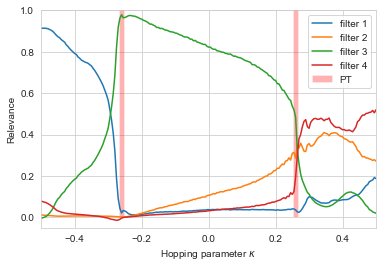

In [11]:
# plot relevances

plt.figure()
total_rel = np.sum(relevances, axis = 0)
for i in range(4):
    plt.plot(k, relevances[i]/total_rel, alpha =1, label = f'filter {i+1}')

plt.ylabel('Relevance')
plt.xlabel(r'Hopping parameter $\kappa$')

#plt.plot(k, (relevances[1]+relevances[3])/total_rel, linestyle='--', color ='grey', label='filter 2+4')
plt.bar([-0.26, 0.26], height = 1.1 , bottom = -0., width = 0.015, color = 'r', alpha = 0.3, label='PT')

plt.legend()
plt.ylim([-0.05, 1.])
plt.xlim([-0.5, 0.5])

if saveplot: plt.savefig('models/lrp_2d/rels')
plt.show()


In [4]:
#torch.save(model, 'models/lrp_2d/model.pt')